In [1]:
import numpy as np
from IPython.display import Audio, display
import torch
import random
from torch import optim
import math

import copy
import torch.utils.data as data_utils
import numpy
import matplotlib.pyplot as plt

mySeed = 666
random.seed(mySeed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device

device(type='cuda', index=0)

In [2]:
motifs_train = (np.genfromtxt('data_filtered/motifs_train.csv',dtype='U'))
motifxFamMatrix_train = np.genfromtxt('data_filtered/motifxFamMatrix_train.csv',delimiter=',',dtype=int)

motifs_test = (np.genfromtxt('data_filtered/motifs_test.csv',dtype='U'))
motifxFamMatrix_test = np.genfromtxt('data_filtered/motifxFamMatrix_test.csv',delimiter=',',dtype=int)

fams = (np.genfromtxt('data_filtered/fams.csv',dtype='U'))

motifs_all = np.hstack((motifs_train,motifs_test))
motifxFamMatrix_all = np.vstack((motifxFamMatrix_train,motifxFamMatrix_test))

In [3]:
## split train into train and val sets ...

idc_val = random.sample(range(len(motifs_train)), len(motifs_train)//8)
idc_train = [i for i in range(len(motifs_train)) if i not in idc_val]

motifs_val = motifs_train[idc_val]
motifxFamMatrix_val = motifxFamMatrix_train[idc_val]

motifs_train = motifs_train[idc_train]
motifxFamMatrix_train = motifxFamMatrix_train[idc_train]

target_train = torch.tensor(motifxFamMatrix_train).float()
target_val = torch.tensor(motifxFamMatrix_val).float()
target_test = torch.tensor(motifxFamMatrix_test).float()

In [4]:
print(target_train.shape)
print(target_val.shape)
print(target_test.shape)

print(motifs_train.shape)
print(motifs_val.shape)
print(motifs_test.shape)

torch.Size([5844, 8])
torch.Size([834, 8])
torch.Size([857, 8])
(5844,)
(834,)
(857,)


In [5]:
all_characters = []
for motif in motifs_all:
    for c in motif:
        all_characters.append(c)
amino_acids = ''.join(list(set(all_characters)))

In [6]:
len(amino_acids)*15

330

In [7]:
amino_acids

'DIYFTXKEPASHGQVL_WRNMC'

In [8]:
pamFams = (np.genfromtxt('data_raw/fams_forPamDistMatrix_19.10.16.csv',dtype='U'))
pamMatrix = (np.genfromtxt('data_raw/famDistanceMatrix_pam_19.10.16.csv',delimiter=',',dtype=float))

for i,each in enumerate(pamFams):
    pamFams[i] = each.upper()

famDistMatrix = np.full((len(fams),len(fams)),-1.0)

for fam in fams:
    fIdx1_set = np.where(fams==fam)[0][0]
    fIdx1_get = np.where(pamFams==fam)[0][0]
    for fam2 in fams:
        fIdx2_set = np.where(fams==fam2)[0][0]
        fIdx2_get = np.where(pamFams==fam2)[0][0]
        famDistMatrix[fIdx1_set][fIdx2_set] = pamMatrix[fIdx1_get][fIdx2_get]
    

### <font color=blue> Normalize fam distances.

In [9]:
maximum = np.max(famDistMatrix)
minimum = np.min(famDistMatrix)

famDistMatrix_scaled = np.array((famDistMatrix))
for i in range(len(fams)):
    for j in range(len(fams)):
        famDistMatrix_scaled[i][j] = float(famDistMatrix[i][j]-minimum)/(maximum-minimum) 

In [10]:
famDistMatrix = famDistMatrix_scaled

In [11]:
def allDone():
    urL = 'http://www.wavsource.com/snds_2018-06-03_5106726768923853/animals/cat_meow2.wav'
    display(Audio(url=urL, autoplay=True))
    
allDone()

In [12]:
fam_counts = []
for fIdx,fam in enumerate(motifxFamMatrix_train.T):
#     print (fams[fIdx],np.sum(motifxFamMatrix_train.T[fIdx]))
    fam_counts.append(np.sum(motifxFamMatrix_train.T[fIdx]))
fam_counts = np.array(fam_counts)

normalized_fam_counts = fam_counts / np.sqrt(np.sum(fam_counts**2))

for i in range(len(normalized_fam_counts)):
    normalized_fam_counts[i] = 1-normalized_fam_counts[i]
normalized_fam_counts = np.array(normalized_fam_counts) 
normalized_fam_counts = torch.from_numpy( np.array(normalized_fam_counts)) 
normalized_fam_counts = normalized_fam_counts.double()
normalized_fam_counts = normalized_fam_counts.to(device)

In [13]:
for fIdx,fam in enumerate(motifxFamMatrix_all.T):
    print (fams[fIdx],np.sum(motifxFamMatrix_all.T[fIdx]))

PKA 1533
AKT 464
CDK 903
MAPK 1514
SRC 993
CK2 900
PKC 1801
PIKK 574


In [14]:
_motifs = []
for fIdx,fam in enumerate(motifxFamMatrix_all.T):
    for mIdx,motif in enumerate(fam):
        if motif==1 and motifs_all[mIdx] not in _motifs:
            _motifs.append(motifs_all[mIdx])
#     print (fams[fIdx],np.sum(motifxFamMatrix_all.T[fIdx]))

In [15]:
def letterToIndex(letter):
    return amino_acids.find(letter)

def motifToStringTensor(motif):
    motif = [letterToIndex(x) for x in motif]
    motif = torch.tensor(motif).unsqueeze(1)
    return (motif)

In [16]:
pos_train = np.genfromtxt('siameseResults/02_embedding_motifs_train.csv',
                          delimiter=',',dtype=float)
dim3 = pos_train.shape[1] // 15

pos_train = pos_train.reshape(pos_train.shape[0],15,dim3)
pos_val = pos_train[idc_val]
pos_train = pos_train[idc_train]

pos_test = np.genfromtxt('siameseResults/02_embedding_motifs_test.csv',
                         delimiter=',',dtype=float)
pos_test = pos_test.reshape(pos_test.shape[0],15,dim3)

In [17]:
print(pos_train.shape)
print(pos_val.shape)
print(pos_test.shape)

(5844, 15, 100)
(834, 15, 100)
(857, 15, 100)


In [18]:
def letterToIndex(letter):
    return amino_acids.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, len(amino_acids))
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, len(amino_acids))
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor.squeeze()

In [19]:
features_train = [] 
features_val = [] 
features_test = [] 

for mIdx, motif in enumerate(motifs_train):
    motif_tensor = lineToTensor(motif).float() ########################
    coords = torch.tensor(pos_train[mIdx])
    feature = torch.cat((motif_tensor.float(), coords.float()), 1)
    features_train.append(torch.tensor(feature.detach().numpy())) ########################
features_train = torch.stack(features_train)

for mIdx, motif in enumerate(motifs_val):
    motif_tensor = lineToTensor(motif).float() ########################
    coords = torch.tensor(pos_val[mIdx])
    feature = torch.cat((motif_tensor.float(), coords.float()), 1)
    features_val.append(torch.tensor(feature.detach().numpy())) ########################
features_val = torch.stack(features_val)

for mIdx, motif in enumerate(motifs_test):
    motif_tensor = lineToTensor(motif).float() ########################
    coords = torch.tensor(pos_test[mIdx])
    feature = torch.cat((motif_tensor.float(), coords.float()), 1)
    features_test.append(torch.tensor(feature.detach().numpy())) ########################
features_test = torch.stack(features_test)

In [20]:
# features_test

In [21]:
print (features_train.shape)
print (features_val.shape)
print (features_test.shape)

torch.Size([5844, 15, 122])
torch.Size([834, 15, 122])
torch.Size([857, 15, 122])


In [22]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
import numpy as np

def getMicroROC(y_test, y_score):
        
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(len(fams)):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        
    return roc_auc["micro"]

In [23]:
from itertools import chain
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

def getPRC(y_test, y_score):
        
    precision = dict()
    recall = dict()
    average_precision = dict()
        
    for i in range(len(fams)):
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])
        
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(), y_score.ravel())
    average_precision["micro"] = average_precision_score(y_test, y_score, average="micro")
        
    return average_precision["micro"]

In [24]:
def eval_model(model, thresh=0.5):
        
    BATCH_SIZE = len(motifs_test)

    test = data_utils.TensorDataset(features_test, target_test)
    test_loader = data_utils.DataLoader(test, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
    
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        sentence = inputs[:,:,:len(amino_acids)]
        coords = inputs[:,:,len(amino_acids):]
        outputs = model(sentence=sentence,coords=coords)   # Set model to evaluate mode

        accuracy = 0.0
        for i,out in enumerate(outputs):
            pred = numpy.where(out.cpu().detach().numpy() > thresh)[0]
            if len(pred)<1:
                pred = [numpy.argmax(out.cpu().detach().numpy())]
            true = numpy.where(labels.data.cpu()[i]==1)[0]
            if any(true) in pred:
                accuracy+=1

        y_score = outputs.cpu().detach().numpy()
        y_test = numpy.array(labels.cpu())
        
        print(accuracy)
        
        return (accuracy/BATCH_SIZE, y_score, y_test)

In [25]:
catDrpt = 0.0

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F

HIDDEN_DIM_0 = 64
HIDDEN_DIM_1 = 32
OUT_DIM = len(fams)

class Model(nn.Module):
    def __init__(self, batch_size, motifDrpt, coordDrpt, catDrpt):
        super(Model, self).__init__()
        
        self.motif_conv1 = nn.Conv1d(in_channels=len(amino_acids), out_channels=HIDDEN_DIM_0, kernel_size=1, stride=1)
        self.motif_conv2 = nn.Conv1d(in_channels=HIDDEN_DIM_0, out_channels=HIDDEN_DIM_1, kernel_size=2, stride=1)
        self.motif_conv3 = nn.Conv1d(in_channels=HIDDEN_DIM_1, out_channels=HIDDEN_DIM_1, kernel_size=3, stride=1)
        self.motif_fc1 = nn.Linear(384, HIDDEN_DIM_0) # 192 #768
        self.motif_fc2 = nn.Linear(HIDDEN_DIM_0, HIDDEN_DIM_0)
        
                
        # coords CNN 
        self.conv1 = nn.Conv1d(in_channels=pos_train.shape[2], out_channels=HIDDEN_DIM_0, kernel_size=1, stride=1)
        self.conv2 = nn.Conv1d(in_channels=HIDDEN_DIM_0, out_channels=HIDDEN_DIM_1, kernel_size=2, stride=1)
        self.conv3 = nn.Conv1d(in_channels=HIDDEN_DIM_1, out_channels=HIDDEN_DIM_1, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(384, HIDDEN_DIM_0) # 192 #768            
        self.fc2 = nn.Linear(HIDDEN_DIM_0, HIDDEN_DIM_0)

        # concat
        self.cat_fc1 = nn.Linear(HIDDEN_DIM_0 + HIDDEN_DIM_0, HIDDEN_DIM_0)
        self.cat_fc2 = nn.Linear(HIDDEN_DIM_0, HIDDEN_DIM_0)
        self.cat_bn2 = nn.BatchNorm1d(HIDDEN_DIM_0)
        self.cat_out = nn.Linear(HIDDEN_DIM_0, OUT_DIM)
        
        self.output = nn.Linear(HIDDEN_DIM_0, OUT_DIM)
        self.sigmoid = nn.Sigmoid()
        
        self.relu = nn.ReLU()
        self.bn0 = nn.BatchNorm1d(HIDDEN_DIM_0)
        self.bn1 = nn.BatchNorm1d(HIDDEN_DIM_1)
        
        myMotifDrpt = motifDrpt
        myCoordDrpt = coordDrpt
        myCatDrpt = catDrpt
        
        self.dropout_motifs = nn.Dropout(p=myMotifDrpt)
        self.dropout_coords = nn.Dropout(p=myCoordDrpt)
        self.dropout_cat = nn.Dropout(p=myCatDrpt)
        
        self.dropout_ablate = nn.Dropout(p=1.00)

    def forward(self, sentence, coords, version='seqCoord'):
        
#         print(sentence.shape, coords.shape)

        # motif CNN
        sentence = sentence.transpose(1,2).float()

        motif_conv1 = self.motif_conv1( sentence ) 
        motif_conv1 = self.relu( motif_conv1 )
        motif_conv1 = self.dropout_motifs( motif_conv1 )
        motif_conv2 = self.motif_conv2( motif_conv1 ) 
        motif_conv2 = self.relu( motif_conv2 )
        motif_conv2 = self.dropout_motifs( motif_conv2 )
        motif_conv3 = self.motif_conv3( motif_conv2 ) 
        motif_conv3 = self.relu( motif_conv3 )
        motif_conv3 = self.dropout_motifs( motif_conv3 )
        motif_conv3 = motif_conv3.reshape(motif_conv3.shape[0],motif_conv3.shape[1]*motif_conv3.shape[2])
                
        motif_fc1 = self.motif_fc1( motif_conv3 )
        motif_fc1 = self.bn0( motif_fc1 )
        motif_fc1 = self.relu( motif_fc1 )
        motif_fc1 = self.dropout_motifs( motif_fc1 )
        
        motif_fc2 = self.motif_fc2( motif_fc1 )
        motif_fc2 = self.bn0( motif_fc2 )
        motif_fc2 = self.relu( motif_fc2 )
        motif_out = self.dropout_motifs( motif_fc2 )
        
        # coords CNN 
        coords = coords.transpose(1,2).float()

#         print (coords.shape)   
        conv1 = self.conv1( coords ) 
        conv1 = self.relu( conv1 )
        conv1 = self.dropout_coords( conv1 )
#         print (conv1.shape)  
        conv2 = self.conv2( conv1 ) 
        conv2 = self.relu( conv2 )
        conv2 = self.dropout_coords( conv2 )
#         print (conv2.shape) 
        conv3 = self.conv3( conv2 ) 
        conv3 = self.relu( conv3 )
        conv3 = self.dropout_coords( conv3 )
#         print(conv3.shape)
        conv3 = conv3.reshape(conv3.shape[0],conv3.shape[1]*conv3.shape[2])
        
#         print(conv3.shape)

        fc1 = self.fc1( conv3 )
        fc1 = self.bn0( fc1 )
        fc1 = self.relu( fc1 )
        fc1 = self.dropout_coords( fc1 )
#         print(fc1.shape)
#         print("==============")
        
        fc1 = self.fc2( fc1 )
        fc1 = self.bn0( fc1 )
        fc1 = self.relu( fc1 )
        
        # concat layers
        if version=='seqCoord':
            coords_out = self.dropout_coords( fc1 ) # seqCoord version
        else: 
            coords_out = self.dropout_ablate( fc1 ) # seq-only version
            
        cat_init = torch.cat((motif_out, motif_out), 1) 
            
        cat_fc1 = self.cat_fc1(cat_init)
        cat_fc1 = self.bn0(cat_fc1)
        cat_fc1 = self.relu(cat_fc1)
        cat_fc1 = self.dropout_cat(cat_fc1)
        
#         cat_fc2 = self.cat_fc2(cat_fc1)
#         cat_fc2 = self.bn0(cat_fc2)
#         cat_fc2 = self.relu(cat_fc2)
#         cat_fc2 = self.dropout(cat_fc2)
        
        cat_out = self.cat_out( cat_fc1 )

        cat_sigmoid = self.sigmoid(cat_out)
   
        return cat_sigmoid

In [51]:
def train_model(model, optimizer, scheduler, num_epochs=25, 
                batch_size=32, myLoss='BCE',stopper='ROC',
                thisVersion='seqCoord'):
    tLoss = []
    tRoc = []
    tPrc = []
    
    vLoss = []
    vRoc = []
    vPrc = []
    
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_roc = 0.0
    best_loss = 100000.0
    best_prc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        avg_running_roc = 0.0
        avg_best_roc = 0.0
        blah = 0
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                
                train = data_utils.TensorDataset(features_train, target_train)
                train_loader = data_utils.DataLoader(train, batch_size=batch_size, 
                                                     shuffle=True, drop_last=True)

                if scheduler:
                    scheduler.step()
                model.train()  # Set model to training mode
            
            else:
                train = data_utils.TensorDataset(features_val, target_val)
                train_loader = data_utils.DataLoader(train, batch_size=len(idc_val), 
                                                     shuffle=True, drop_last=True)
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_roc = 0.0
            running_prc = 0.0

            # Iterate over data.
            poo = 0
            poo2 = 0
            for inputs, labels in train_loader:
                
                inputs = inputs.to(device)
                labels = labels.to(device)
                      
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    sentence = inputs[:,:,:len(amino_acids)]
                    coords = inputs[:,:,len(amino_acids):]

                    outputs = model.forward(sentence=sentence, coords=coords, 
                                            version=thisVersion)
                    
                    
                    # three different losses 
                    if myLoss=='BCE':
                        criterion = nn.BCELoss()
                        loss = criterion(outputs, labels)
                    elif myLoss=='BCEphylo':
                        loss = BCE_phylo(outputs, labels) 
                    elif myLoss=='MSEphylo':
                        loss = MSE_phylo(outputs, labels) 
                    loss = loss.mean().float()
                        
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                y_test = numpy.array(labels.cpu())
                y_score = outputs.cpu().detach().numpy()
                roc = getMicroROC(y_test, y_score)
                prc = getPRC(y_test, y_score)
                
                # backpropagate loss
                running_loss += (loss.item() * inputs.size(0)) # * (1.0-roc)

                if not numpy.isnan(roc):
                    running_roc += roc
                    avg_running_roc += roc
                    poo+=1
                    blah+=1
                
                if not numpy.isnan(prc):
                    running_prc +=  prc
                    poo2+=1
                    
            epoch_loss = running_loss / len(train)
            epoch_roc = running_roc / poo
            epoch_prc = running_prc / poo2
            
            avg_epoch_roc = avg_running_roc / blah


            if phase =='train':
                tLoss.append(epoch_loss)
                tRoc.append(epoch_roc)
                tPrc.append(epoch_prc)
            else:
                vLoss.append(epoch_loss)
                vRoc.append(epoch_roc)
                vPrc.append(epoch_prc)
                
            avg_best_roc += avg_epoch_roc
                
            print('{} Loss: {:.4f}, ROC: {:.4f}, PRC: {:.4f}'.format(
                phase, epoch_loss, epoch_roc, epoch_prc))
            
            # choose between loss and roc metric
            if phase == 'val' and epoch_loss <= best_loss and epoch >= 50: # 5th epoch !!!
                best_loss = epoch_loss
                if stopper=='Loss':
                    best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'val' and epoch_roc >= best_roc and epoch >= 50: # 5th epoch !!!
                best_roc = epoch_roc
                if stopper=='ROC':
                    best_model_wts = copy.deepcopy(model.state_dict())
                                        
            if phase == 'val' and epoch_prc >= best_prc and epoch >= 50: # 5th epoch !!!
                best_prc = epoch_prc
                if stopper=='PRC':
                    best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val ROC: {:4f}'.format(best_roc))
    print('Best val PRC: {:4f}'.format(best_prc))
    print('Best val Loss: {:4f}'.format(best_loss))
    

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, tLoss, tRoc, vLoss, vRoc, best_roc

In [387]:
def MSE_phylo(output, target):
    
#     output = output.reshape(output.shape[0],output.shape[2],output.shape[1])
    
    weights = numpy.ones((output.shape[0],output.shape[1]))

    for i,t in enumerate(target):
        t = t.cpu()
        wIdc = numpy.where(t.detach().numpy()==1)[0]

        if len(wIdc)==0:
            weights[i] = 0.000001
            continue
        theseWeights = numpy.ones((len(fams)))
        for wIdx in wIdc:
            
            # want inter-fam weights to be distance (larger number, less related = more weight)
            thisWeight = famDistMatrix[wIdx].copy() # list of fam distances from true fam
            # want intra-fam weights to be similarity (larger number = more weight)
            thisWeight[wIdx] =  1.00 - famDistMatrix[wIdx][wIdx].copy()
            theseWeights+=thisWeight # add to existing list of fam distances, respectively (element wise)
            
        fWeight = theseWeights/len(fams) # take average
        weights[i] = fWeight 
    weights = torch.tensor(weights)
    weights = weights.to(device)

    return (output.double()-target.double()+1e-6)**2.00*(weights.double()).mean().float()

#     return (output.double()-target.double()+1e-6)**2.00



In [388]:
from torch.optim import lr_scheduler
import time

BS = 512
tLoss1 = []
tAcc1 = []
vLoss1 = []
vAcc1 = []

totAcc = []
totY_score = []
totY_test = []

start = time.time()

###################################

motifDrpt = 0.4
coordDrpt = 0.5
catDrpt = 0.00

versionToUse = 'seqCoord' # 'seqs' 'seqCoord'
thisLoss = 'MSEphylo' # 'BCE' 'MSEphylo'

stopper = 'ROC' 
num_epochs = 500


###################################


thisModel = Model(BS,motifDrpt,coordDrpt,catDrpt) 
thisModel = thisModel.to(device)
optimizer = optim.Adam(thisModel.parameters(),lr = 0.0015)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

myBestVal = 0
thisModel, tL, tA, vL, vA, myVal = train_model(thisModel, optimizer, False, 
                                             num_epochs=num_epochs, batch_size=BS, 
                                             myLoss=thisLoss, 
                                             stopper=stopper,
                                             thisVersion=versionToUse)

if myVal >= myBestVal:
    myBestVal = myVal
    myBestModel = thisModel

tLoss1.append(tL)
tAcc1.append(tA)
vLoss1.append(vL)
vAcc1.append(vA)

print('\n - - - - - TIME: %s mins' % ((time.time() - start)/60.0),'- - - - -')
print ('\n - - - - - BEST VAL: ',myBestVal,'- - - - -')
    
(accuracy, y_score, y_test) = eval_model(myBestModel, thresh=0.5)
totAcc.append(accuracy)
totY_score.extend(y_score)
totY_test.extend(y_test)

Epoch 0/499
----------
train Loss: 0.0552, ROC: 0.4748, PRC: 0.1341
val Loss: 0.0577, ROC: 0.4688, PRC: 0.1297

Epoch 1/499
----------
train Loss: 0.0418, ROC: 0.4854, PRC: 0.1372
val Loss: 0.0514, ROC: 0.4481, PRC: 0.1432

Epoch 2/499
----------
train Loss: 0.0343, ROC: 0.5068, PRC: 0.1446
val Loss: 0.0481, ROC: 0.4732, PRC: 0.1797

Epoch 3/499
----------
train Loss: 0.0307, ROC: 0.5490, PRC: 0.1664
val Loss: 0.0458, ROC: 0.4987, PRC: 0.1951

Epoch 4/499
----------
train Loss: 0.0287, ROC: 0.6299, PRC: 0.2191
val Loss: 0.0433, ROC: 0.5309, PRC: 0.1957

Epoch 5/499
----------
train Loss: 0.0271, ROC: 0.7189, PRC: 0.3077
val Loss: 0.0412, ROC: 0.5870, PRC: 0.2147

Epoch 6/499
----------
train Loss: 0.0251, ROC: 0.7900, PRC: 0.4221
val Loss: 0.0393, ROC: 0.6555, PRC: 0.2986

Epoch 7/499
----------
train Loss: 0.0231, ROC: 0.8297, PRC: 0.5128
val Loss: 0.0379, ROC: 0.7147, PRC: 0.4440

Epoch 8/499
----------
train Loss: 0.0215, ROC: 0.8493, PRC: 0.5628
val Loss: 0.0353, ROC: 0.7471, PRC: 

train Loss: 0.0145, ROC: 0.9293, PRC: 0.7608
val Loss: 0.0178, ROC: 0.9124, PRC: 0.7203

Epoch 74/499
----------
train Loss: 0.0145, ROC: 0.9290, PRC: 0.7596
val Loss: 0.0178, ROC: 0.9132, PRC: 0.7272

Epoch 75/499
----------
train Loss: 0.0145, ROC: 0.9304, PRC: 0.7600
val Loss: 0.0177, ROC: 0.9144, PRC: 0.7309

Epoch 76/499
----------
train Loss: 0.0147, ROC: 0.9273, PRC: 0.7542
val Loss: 0.0176, ROC: 0.9152, PRC: 0.7357

Epoch 77/499
----------
train Loss: 0.0147, ROC: 0.9274, PRC: 0.7535
val Loss: 0.0177, ROC: 0.9143, PRC: 0.7344

Epoch 78/499
----------
train Loss: 0.0146, ROC: 0.9277, PRC: 0.7561
val Loss: 0.0178, ROC: 0.9141, PRC: 0.7350

Epoch 79/499
----------
train Loss: 0.0145, ROC: 0.9307, PRC: 0.7617
val Loss: 0.0176, ROC: 0.9151, PRC: 0.7375

Epoch 80/499
----------
train Loss: 0.0145, ROC: 0.9288, PRC: 0.7575
val Loss: 0.0174, ROC: 0.9153, PRC: 0.7366

Epoch 81/499
----------
train Loss: 0.0145, ROC: 0.9271, PRC: 0.7576
val Loss: 0.0175, ROC: 0.9157, PRC: 0.7347

Epoch 8

train Loss: 0.0138, ROC: 0.9360, PRC: 0.7804
val Loss: 0.0176, ROC: 0.9236, PRC: 0.7379

Epoch 147/499
----------
train Loss: 0.0139, ROC: 0.9345, PRC: 0.7748
val Loss: 0.0176, ROC: 0.9232, PRC: 0.7314

Epoch 148/499
----------
train Loss: 0.0141, ROC: 0.9348, PRC: 0.7712
val Loss: 0.0175, ROC: 0.9244, PRC: 0.7362

Epoch 149/499
----------
train Loss: 0.0139, ROC: 0.9346, PRC: 0.7752
val Loss: 0.0174, ROC: 0.9259, PRC: 0.7462

Epoch 150/499
----------
train Loss: 0.0138, ROC: 0.9368, PRC: 0.7810
val Loss: 0.0174, ROC: 0.9231, PRC: 0.7359

Epoch 151/499
----------
train Loss: 0.0138, ROC: 0.9359, PRC: 0.7799
val Loss: 0.0174, ROC: 0.9230, PRC: 0.7357

Epoch 152/499
----------
train Loss: 0.0138, ROC: 0.9359, PRC: 0.7785
val Loss: 0.0175, ROC: 0.9230, PRC: 0.7343

Epoch 153/499
----------
train Loss: 0.0140, ROC: 0.9363, PRC: 0.7752
val Loss: 0.0176, ROC: 0.9219, PRC: 0.7299

Epoch 154/499
----------
train Loss: 0.0138, ROC: 0.9361, PRC: 0.7783
val Loss: 0.0176, ROC: 0.9216, PRC: 0.7265


train Loss: 0.0133, ROC: 0.9392, PRC: 0.7915
val Loss: 0.0171, ROC: 0.9261, PRC: 0.7483

Epoch 219/499
----------
train Loss: 0.0134, ROC: 0.9378, PRC: 0.7865
val Loss: 0.0171, ROC: 0.9249, PRC: 0.7447

Epoch 220/499
----------
train Loss: 0.0136, ROC: 0.9372, PRC: 0.7872
val Loss: 0.0171, ROC: 0.9250, PRC: 0.7450

Epoch 221/499
----------
train Loss: 0.0136, ROC: 0.9365, PRC: 0.7848
val Loss: 0.0174, ROC: 0.9230, PRC: 0.7355

Epoch 222/499
----------
train Loss: 0.0136, ROC: 0.9374, PRC: 0.7863
val Loss: 0.0177, ROC: 0.9237, PRC: 0.7401

Epoch 223/499
----------
train Loss: 0.0135, ROC: 0.9365, PRC: 0.7870
val Loss: 0.0176, ROC: 0.9239, PRC: 0.7392

Epoch 224/499
----------
train Loss: 0.0135, ROC: 0.9372, PRC: 0.7856
val Loss: 0.0174, ROC: 0.9242, PRC: 0.7422

Epoch 225/499
----------
train Loss: 0.0136, ROC: 0.9373, PRC: 0.7848
val Loss: 0.0171, ROC: 0.9258, PRC: 0.7497

Epoch 226/499
----------
train Loss: 0.0135, ROC: 0.9374, PRC: 0.7874
val Loss: 0.0171, ROC: 0.9257, PRC: 0.7477


train Loss: 0.0132, ROC: 0.9398, PRC: 0.7933
val Loss: 0.0170, ROC: 0.9267, PRC: 0.7458

Epoch 291/499
----------
train Loss: 0.0133, ROC: 0.9392, PRC: 0.7909
val Loss: 0.0168, ROC: 0.9275, PRC: 0.7510

Epoch 292/499
----------
train Loss: 0.0131, ROC: 0.9406, PRC: 0.7970
val Loss: 0.0170, ROC: 0.9269, PRC: 0.7473

Epoch 293/499
----------
train Loss: 0.0132, ROC: 0.9400, PRC: 0.7960
val Loss: 0.0168, ROC: 0.9271, PRC: 0.7498

Epoch 294/499
----------
train Loss: 0.0134, ROC: 0.9388, PRC: 0.7900
val Loss: 0.0169, ROC: 0.9268, PRC: 0.7497

Epoch 295/499
----------
train Loss: 0.0130, ROC: 0.9426, PRC: 0.8001
val Loss: 0.0169, ROC: 0.9270, PRC: 0.7484

Epoch 296/499
----------
train Loss: 0.0131, ROC: 0.9397, PRC: 0.7979
val Loss: 0.0168, ROC: 0.9272, PRC: 0.7477

Epoch 297/499
----------
train Loss: 0.0134, ROC: 0.9390, PRC: 0.7880
val Loss: 0.0168, ROC: 0.9274, PRC: 0.7478

Epoch 298/499
----------
train Loss: 0.0130, ROC: 0.9420, PRC: 0.7988
val Loss: 0.0169, ROC: 0.9272, PRC: 0.7485


train Loss: 0.0131, ROC: 0.9419, PRC: 0.7970
val Loss: 0.0167, ROC: 0.9279, PRC: 0.7489

Epoch 363/499
----------
train Loss: 0.0130, ROC: 0.9426, PRC: 0.8004
val Loss: 0.0169, ROC: 0.9282, PRC: 0.7493

Epoch 364/499
----------
train Loss: 0.0132, ROC: 0.9394, PRC: 0.7952
val Loss: 0.0170, ROC: 0.9286, PRC: 0.7514

Epoch 365/499
----------
train Loss: 0.0130, ROC: 0.9398, PRC: 0.7969
val Loss: 0.0169, ROC: 0.9278, PRC: 0.7483

Epoch 366/499
----------
train Loss: 0.0130, ROC: 0.9416, PRC: 0.7995
val Loss: 0.0168, ROC: 0.9290, PRC: 0.7530

Epoch 367/499
----------
train Loss: 0.0130, ROC: 0.9408, PRC: 0.7986
val Loss: 0.0168, ROC: 0.9294, PRC: 0.7556

Epoch 368/499
----------
train Loss: 0.0130, ROC: 0.9413, PRC: 0.7987
val Loss: 0.0167, ROC: 0.9286, PRC: 0.7520

Epoch 369/499
----------
train Loss: 0.0130, ROC: 0.9412, PRC: 0.7976
val Loss: 0.0170, ROC: 0.9268, PRC: 0.7445

Epoch 370/499
----------
train Loss: 0.0132, ROC: 0.9406, PRC: 0.7962
val Loss: 0.0167, ROC: 0.9275, PRC: 0.7487


train Loss: 0.0130, ROC: 0.9410, PRC: 0.7997
val Loss: 0.0170, ROC: 0.9295, PRC: 0.7526

Epoch 435/499
----------
train Loss: 0.0129, ROC: 0.9430, PRC: 0.8040
val Loss: 0.0171, ROC: 0.9297, PRC: 0.7535

Epoch 436/499
----------
train Loss: 0.0129, ROC: 0.9426, PRC: 0.8024
val Loss: 0.0175, ROC: 0.9289, PRC: 0.7511

Epoch 437/499
----------
train Loss: 0.0129, ROC: 0.9423, PRC: 0.8018
val Loss: 0.0172, ROC: 0.9295, PRC: 0.7543

Epoch 438/499
----------
train Loss: 0.0130, ROC: 0.9412, PRC: 0.7982
val Loss: 0.0169, ROC: 0.9291, PRC: 0.7523

Epoch 439/499
----------
train Loss: 0.0128, ROC: 0.9435, PRC: 0.8066
val Loss: 0.0170, ROC: 0.9285, PRC: 0.7494

Epoch 440/499
----------
train Loss: 0.0128, ROC: 0.9451, PRC: 0.8062
val Loss: 0.0172, ROC: 0.9293, PRC: 0.7529

Epoch 441/499
----------
train Loss: 0.0130, ROC: 0.9420, PRC: 0.7996
val Loss: 0.0171, ROC: 0.9289, PRC: 0.7521

Epoch 442/499
----------
train Loss: 0.0130, ROC: 0.9415, PRC: 0.7982
val Loss: 0.0173, ROC: 0.9283, PRC: 0.7496


In [389]:
def eval_model(model, thresh=0.5):
    
    model.eval()
        
    BATCH_SIZE = len(motifs_test)

    test = data_utils.TensorDataset(features_test, target_test)
    test_loader = data_utils.DataLoader(test, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
    
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        sentence = inputs[:,:,:len(amino_acids)]
        coords = inputs[:,:,len(amino_acids):]
        outputs = model(sentence=sentence,coords=coords)   # Set model to evaluate mode

        accuracy = 0
        totTrues = 0
        for i,out in enumerate(outputs):
            pred = numpy.where(out.cpu().detach().numpy() > thresh)[0]
            if len(pred)<1: 
                pred = [numpy.argmax(out.cpu().detach().numpy())]
            true = numpy.where(labels.data.cpu()[i]==1)[0]
            totTrues += len(true)
            accuracy += len(pred)

        y_score = outputs.cpu().detach().numpy()
        y_test = numpy.array(labels.cpu())
#         print(labels,y_score)
        print("accuracy:",accuracy/totTrues,accuracy,totTrues)
        
        return (accuracy/BATCH_SIZE, y_score, y_test)

In [390]:
# motifDrpt = False
# coordDrpt = False
# catDrpt = False

# totAcc = []
# totY_score = []
# totY_test = []

# myBestModel = Model(BS,motifDrpt,coordDrpt,catDrpt) 
# myBestModel = myBestModel.to(device)


# myBestModel.load_state_dict(torch.load('predModel_results/models/09_seqCoord_666_64-32-8_3conv-2fc-3conv-2fc-1cat_123_0*50motifs-0*50coords-0*00cat_Loss_MSEphylo_256_500_inv02'))
# (accuracy, y_score, y_test) = eval_model(myBestModel, thresh=0.5)

# totAcc.append(accuracy)
# totY_score.extend(y_score)
# totY_test.extend(y_test)

In [391]:
import os
f = "predModelResults/"

allDone()

In [392]:
# os.mkdir(f)

In [393]:
f

'predModelResults/'

In [394]:
# os.mkdir("predModelResults/models/")

In [395]:
run = '19'

versionToUse_ = versionToUse
mySeed_ = str(mySeed)
neurons_ = '%d-%d-%d' % (HIDDEN_DIM_0, HIDDEN_DIM_1, OUT_DIM)
layers_ = '3conv-2fc-3conv-2fc-1cat'
kernels_ = '123'
drpt_ = '%1.2fmotifs-%1.2fcoords-%1.2fcat' % (motifDrpt,coordDrpt,catDrpt)
stopper_ = stopper
thisLoss_ = thisLoss
bs_ =  str(BS)
num_epochs_ = str(num_epochs) 
other_ =  'inv00' #'inv02' # 'inv00'

attributes = [run, versionToUse_, mySeed_, neurons_, layers_, kernels_, drpt_, stopper_, 
              thisLoss_, bs_, num_epochs_, other_]
modelDescription = '_'.join(attributes)
modelDescription = modelDescription.replace('.','*')
modelDescription = modelDescription.replace('~','')
fName = f + 'models/' + modelDescription
fName

'predModelResults/models/19_seqCoord_666_64-32-8_3conv-2fc-3conv-2fc-1cat_123_0*40motifs-0*50coords-0*00cat_ROC_MSEphylo_512_500_inv00'

In [396]:
torch.save(myBestModel.state_dict(), fName)

In [397]:
figFile = f + 'figs/'
# os.mkdir(figFile)

figFile

'predModelResults/figs/'

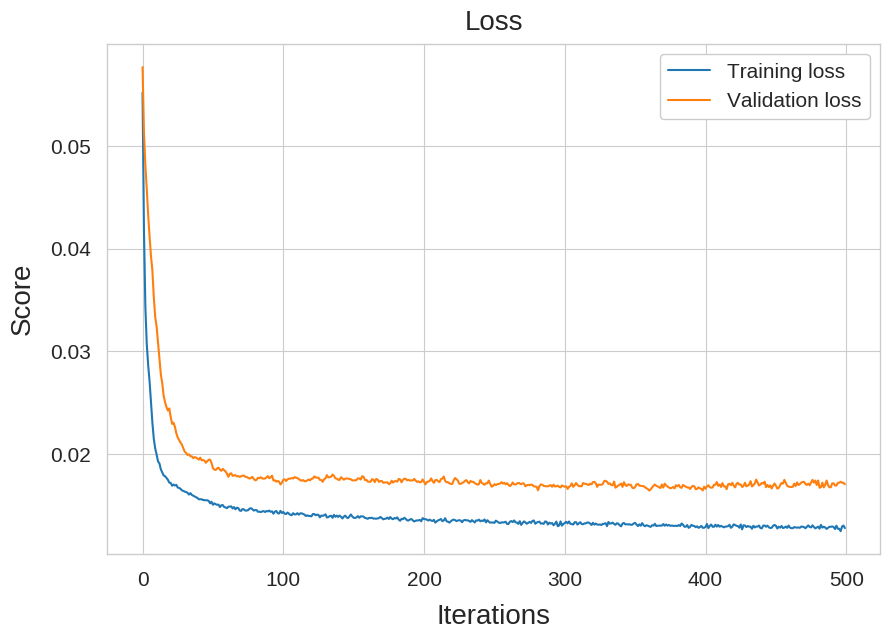

In [398]:
avg_losses = []
for i in range(len(tLoss1[0])):
    avg_loss = sum([x[i] for x in tLoss1]) / len(tLoss1)
    avg_losses.append(avg_loss)
    
avg_val_losses = []
for i in range(len(vLoss1[0])):
    avg_loss = sum([x[i] for x in vLoss1]) / len(vLoss1)
    avg_val_losses.append(avg_loss)
    
avg_acc_history = []
for i in range(len(tAcc1[0])):
    avg_acc = sum([x[i] for x in tAcc1]) / len(tAcc1)
    avg_acc_history.append(avg_acc)
    
avg_val_acc_history = []
for i in range(len(vAcc1[0])):
    avg_acc = sum([x[i] for x in vAcc1]) / len(vAcc1)
    avg_val_acc_history.append(avg_acc)
    
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

plt.rcParams['xtick.major.pad']='12'
plt.rcParams['ytick.major.pad']='12'

# plt.figure(figsize=(18,13))
plt.figure(figsize=(9,6.5))

plt.title("Loss" ,fontsize=20, pad=10)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Iterations', fontsize=20, labelpad=10)
plt.ylabel('Score', fontsize=20, labelpad=10)
plt.plot(avg_losses, label='Training loss', linewidth=1.5)
plt.plot(avg_val_losses, label='Validation loss', linewidth=1.5)
plt.legend(loc='upper right',fontsize=15, facecolor="white",frameon=True,framealpha=1.0)
plt.tight_layout()
plt.savefig(figFile + run + "_loss")

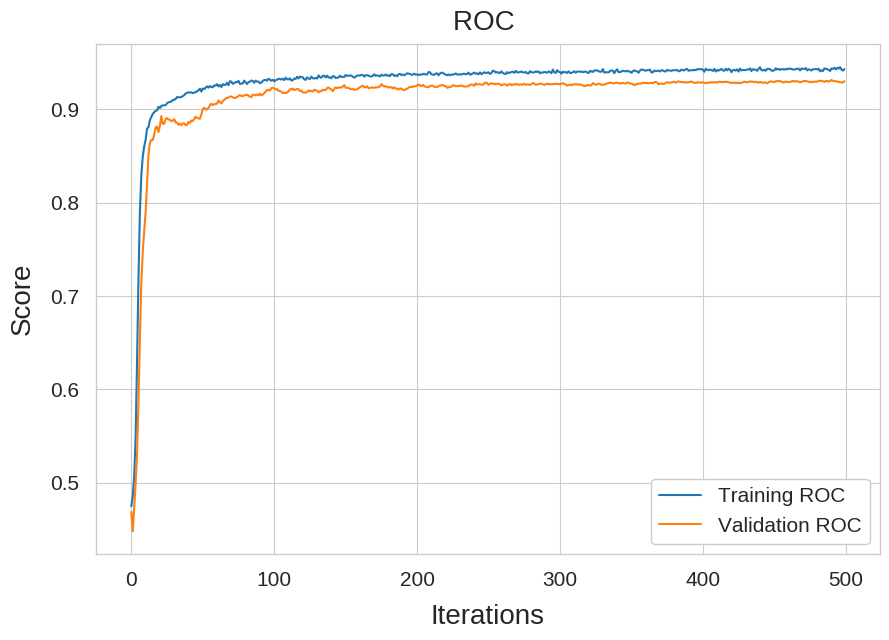

In [399]:
plt.rcParams['xtick.major.pad']='12'
plt.rcParams['ytick.major.pad']='12'

plt.figure(figsize=(9,6.5))
plt.title("%s " % ("ROC"),fontsize=20, pad=10)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Iterations', fontsize=20, labelpad=10)
plt.ylabel('Score', fontsize=20, labelpad=10)
plt.plot(avg_acc_history, label='Training ROC', linewidth=1.5)
plt.plot(avg_val_acc_history, label='Validation ROC', linewidth=1.5)
plt.legend(loc='lower right',fontsize=15, facecolor="white",frameon=True,framealpha=1.0)
plt.tight_layout()
plt.savefig(figFile + run + "_stopper")

In [400]:
y_test = numpy.array(totY_test)
y_score = numpy.array(totY_score)

for i in range(len(y_test)):
    trueIdc = numpy.where(y_test[i]==1)[0]
    predIdc = numpy.where(y_score[i]>0.5)[0]
    if len(predIdc)<1:
        predIdc = [numpy.argmax(y_score[i])]
        
    trueLab = fams[trueIdc]
    predLab = fams[predIdc]
y_test.shape

(857, 8)

In [401]:
from itertools import chain
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(len(fams)):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(y_test, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.3f}'
      .format(average_precision["micro"]))



average_precision["micro"] = average_precision_score(y_test, y_score,
                                                     average="micro")
average_precision["macro"] = average_precision_score(y_test, y_score,
                                                     average="macro")

print('Average precision score, micro-averaged over all classes: {0:0.3f}'
      .format(average_precision["macro"]))

Average precision score, micro-averaged over all classes: 0.774
Average precision score, micro-averaged over all classes: 0.730


In [402]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
import numpy as np

FAM_IDC = [x for x in range(len(fams))]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in FAM_IDC:
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in FAM_IDC]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in FAM_IDC:
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= len(FAM_IDC)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

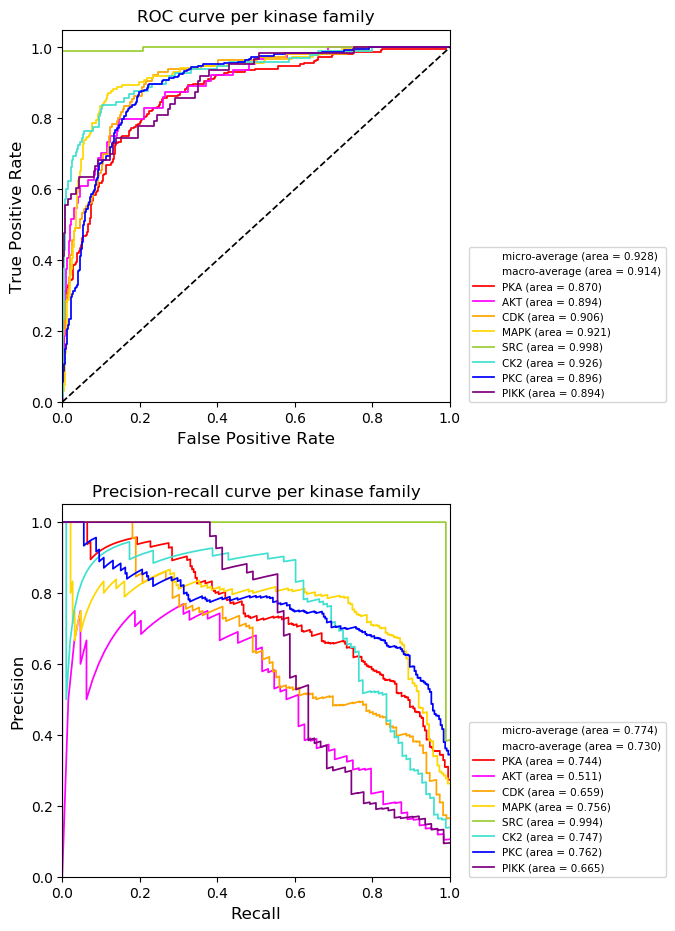

In [403]:
from itertools import cycle

colors = cycle(['red','magenta','orange', 'gold','yellowgreen',
                'turquoise', 'blue', 'purple']) 

plt.style.use('default')
fig, (ax1, ax2) = plt.subplots(2,figsize=(5,11))
lw = 1.25

ax1.plot(fpr["micro"], tpr["micro"],label='micro-average (area = {0:0.3f})'''.format(roc_auc["micro"]), 
         color='white', linestyle=':', linewidth=lw)
ax1.plot(fpr["macro"], tpr["macro"], label='macro-average (area = {0:0.3f})'''.format(roc_auc["macro"]),
         color='white', linestyle=':', linewidth=lw)

for i, color in zip( range( len(fams) ), colors):
    fam = fams[i]
#     print(color)
    ax1.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='{0} (area = {1:0.3f})'
             ''.format(fam, roc_auc[i]))

fig.subplots_adjust(hspace=.275)
ax1.plot([0, 1], [0, 1], 'k--', lw=lw)
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.tick_params(axis="x", labelsize=10)
ax1.tick_params(axis="y", labelsize=10)
ax1.set_xlabel('False Positive Rate',fontsize=12) #20)
ax1.set_ylabel('True Positive Rate',fontsize=12) #20)
ax1.set_title('ROC curve per kinase family',fontsize=12) #=20)
ax1.legend(loc=(1.05, .0), fontsize=7.5) #12.5)

# colors = cycle(['magenta','red','orange', 'gold', '#E3CF57','yellowgreen','green','turquoise','blue','purple','orchid','pink',
#                 'magenta']) 

colors = cycle(['red','magenta','orange', 'gold','yellowgreen',
                'turquoise', 'blue', 'purple']) 

lines = []
labels = []


l, = ax2.plot(recall["micro"], precision["micro"], color='white', lw=1.5,linestyle=':')
lines.append(l)
labels.append('micro-average (area = {0:0.3f})'
              ''.format(average_precision["micro"]))
l, = ax2.plot(recall["micro"], precision["micro"], color='white', lw=1.5,linestyle=':')
lines.append(l)
labels.append('macro-average (area = {0:0.3f})'
              ''.format(average_precision["macro"]))

for i, color in zip(range( len(fams) ), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=lw)
#     print(color)
    lines.append(l)
    fclass = fams[i]
    labels.append('{0} (area = {1:0.3f})'
                  ''.format(fclass, average_precision[i]))

ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.tick_params(axis="x", labelsize=10)
ax2.tick_params(axis="y", labelsize=10)
ax2.set_xlabel('Recall',fontsize=12) #20)
ax2.set_ylabel('Precision',fontsize=12) #20)
ax2.set_title('Precision-recall curve per kinase family',fontsize=12) #=20)
ax2.legend(lines, labels, loc=(1.05, .0), fontsize=7.5) #12.5)

plt.savefig(figFile + run + "_roc_prc", bbox_inches='tight')
plt.show()

In [404]:
def eval_model2(model, thresh=0.5):
        
    BATCH_SIZE = len(motifs_test)

    train = data_utils.TensorDataset(features_test, target_test)
    train_loader = data_utils.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        model.eval()   # Set model to evaluate mode
        
        
        sentence = inputs[:,:,:len(amino_acids)]
        coords = inputs[:,:,len(amino_acids):]
        outputs = model.forward(sentence=sentence, coords=coords)

        confusion = torch.zeros(len(fams), len(fams))
        accuracy = 0.0
        for i,out in enumerate(outputs):
            pred = numpy.where(out.cpu().detach().numpy() > thresh)[0]
            if len(pred)<1:
                pred = [numpy.argmax(out.cpu().detach().numpy())]
            true = numpy.where(labels.data.cpu()[i]==1)[0]
            for pIdx in pred:
                for tIdx in true:
                    confusion[pIdx][tIdx] += 1
            if any(true) in pred:
                accuracy+=1

        y_score = outputs.cpu().detach().numpy()
        y_test = numpy.array(labels.cpu())
        
        print(accuracy)
        
        return (confusion, accuracy/BATCH_SIZE, y_score, y_test)

92.0


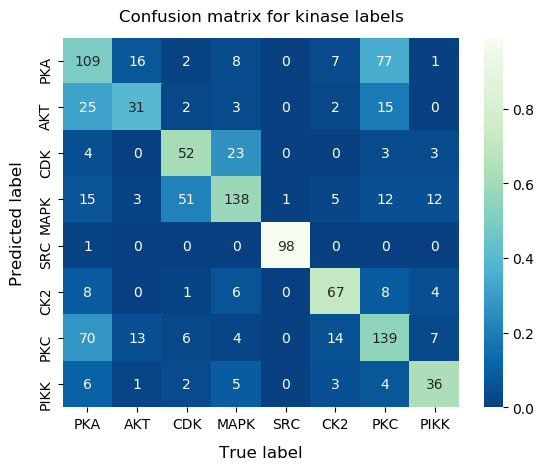

In [405]:
import math

confusion = torch.zeros(len(fams), len(fams))
(confusion, accuracy, y_score, y_test) = eval_model2(myBestModel, thresh=0.5)

labs = confusion.detach().numpy().copy()

for i in range(len(fams)):
    confusion[i] = confusion[i] / confusion[i].sum()
# print (confusion)
for i in range(len(fams)):
    for j in range(len(fams)):
        if math.isnan(confusion[i][j]) or confusion[i][j]==0:
            confusion[i][j]=0
            
import seaborn as sb
heat_map = sb.heatmap(confusion, annot=labs, cmap="GnBu_r", fmt='1.0f',
                      square=False, yticklabels=fams, xticklabels=fams )

b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.xlabel("True label",fontsize=12, labelpad=10)
plt.ylabel("Predicted label",fontsize=12, labelpad=10)
plt.title("Confusion matrix for kinase labels",fontsize=12, pad=12)
plt.savefig(figFile + run + "_conf") #, bbox_inches='tight')
plt.show()

In [205]:
len(motifs_test)

857